# Practical session n°3

Notions:
- Training from scratch
- Validation step
- Learning curves
- Pretraining / Fine tuning
- Data augmentation (DAUG)
- Freezing

Duration: 1 h 30

Now that we have covered the basic building blocks, we will train a Convolutional Neural Network (CNN) on slightly more challenging problems than separation of points in a 2D space:
- handwritten digit recognition (part **I.**)
- binary classification of photos (part **II.**)

The first machine learning problem will give us the opportunity to train a tiny CNN from scratch through a complete training loop (including training and validation steps).
An efficient training from scratch on the second problem would need much more images than the few available photos (200). We hence use one of the most interesting features of the neural networks: once trained on a very big dataset on a very general task, they could be "retrained" (one says fine tuned) on a very specific task that share the same inputs. As such pretrained neural network are much bigger than our first tiny CNN, a graphics card will be used to significantly speed up the process.


### **I.A.** The MNIST Database of Handwritten Digit

The Database of Handwritten Digit of the NIST (National Institute of Standards and Technologogies) comprises 70,000 black and white  images of handwritten digits of 28x28 pixels. A specific dataset object is allocated to it in the torchvision.datasets module. \\
The subsequent cells are designed to import packages, download the MNIST database, define dataLoaders and showcase some images.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
import time

In [2]:
# transforms (format/normalization)
tr=torchvision.transforms.Compose([
   torchvision.transforms.ToTensor(),
   torchvision.transforms.Normalize((0.1307,), (0.3081,))
   ])

# Definition of training sets:
trainval_dataset = datasets.MNIST(root='./data',
                                  train=True,
                                  download=True,
                                  transform=tr)

# Split indices for training and validation
num_images = len(trainval_dataset)
indices = list(range(num_images))
split = int(np.floor(0.2 * num_images))  # 20% validation

# Shuffle indices
np.random.seed(42)  # Seed for reproducibility
np.random.shuffle(indices)

# Create train and validation samplers
train_indices, val_indices = indices[split:], indices[:split]

from torch.utils.data import SubsetRandomSampler
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
train_size = len(train_sampler)
val_size = len(val_sampler)

# Definition of the train/val loaders
bs = 8
num_workers = 2 # try : print(os.cpu_count())

train_loader = DataLoader(trainval_dataset, batch_size=bs,
                          sampler=train_sampler, num_workers=num_workers)
val_loader = DataLoader(trainval_dataset, batch_size=bs,
                        sampler=val_sampler, num_workers=num_workers)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 501kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.74MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.21MB/s]


torch.Size([8, 1, 28, 28])


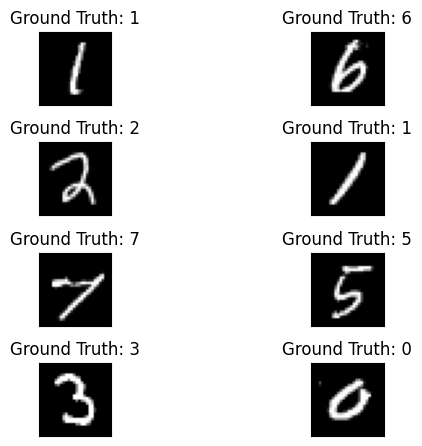

In [3]:
x, t = next(iter(train_loader))

print(x.shape)

fig = plt.figure()
for i in range(8):
  plt.subplot(4,2,i+1)
  plt.tight_layout()
  plt.imshow(x[i,0,:,:], cmap='gray') #, interpolation='none')
  plt.title("Ground Truth: {}".format(t[i]))
  plt.xticks([])
  plt.yticks([])

**Exercise 1**:
- Are images sampled by train_loader and val_loader normalized?
- How much images are in *train_loader* and *val_loader*?
- What will be the role of the validation loader?

### **I.B.** A vanilla CNN

Now, we will define a vanilla CNN with two convolution layers.

**Exercise 2:**  Determine *N* in such a way that the network can accept MNIST images as input.
How outputs will be interpreted after the training ?

In [4]:
# N = ...
### BEGIN SOLUTION
N = 490
### END SOLUTION

class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(10, 10, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(N, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))

        # convert an image to a 1D torch.tensor:
        x = x.view(-1, N)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

### **I.C.** Training of the CNN

To train a CNN, let's define a loss function. Since the log of output probabilities has been computed with *F.log_softmax*, we only need to gather the logits associated with the target classes. This can be done with the torch.gather function (see **P1**), but the standard way in PyTorch is to use *torch.nn.NLLLoss()*.

In [5]:
model = CNN()

#optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

# NLLLoss() will have the same effect as torch.gather (see P1)
loss_fn =  torch.nn.NLLLoss()

A complete training loop has (at least) two phases: weights are updated only in the first phase dedicated to training. During the validation phase, **generalization performance** on independent images is monitored.

**Exercise 3**:
Complete the following code to print the mean loss and the accuracy on the train and validation sets.


In [6]:
train_losses = []
val_losses = []

train_accs = []
val_accs = []



# Initialize time
start_time = time.time()

# Learning Loop:
for epoch in range(6):
    print('epoch :' + str(epoch))

    running_loss_train = 0.
    running_corrects_train = 0.
    running_loss_val = 0.
    running_corrects_val = 0.

    # Training
    for x, label in train_loader:
        optimizer.zero_grad()
        output = model(x)
        l = loss_fn(output, label)
        l.backward()
        optimizer.step()

        # Get predicted classes:
        _, preds = torch.max(output, 1)

        # Counters:
        running_loss_train += l.item() * x.shape[0]
        running_corrects_train += torch.sum(preds == label.data)

    # Calculate training scores and store:
    epoch_loss_train = running_loss_train / train_size
    epoch_acc_train = running_corrects_train.float() / train_size
    train_losses.append(epoch_loss_train)
    train_accs.append(epoch_acc_train)

    print('{} Loss: {:.4f} Acc: {:.4f}'.format(
        'train', epoch_loss_train, epoch_acc_train))


    # validation
    model.eval()

    for x, label in val_loader:

        with torch.no_grad():
            output = model(x)
            l = loss_fn(output, label)

        # Get predicted classes:
        _, preds = torch.max(output, 1)

        # Counters:
        running_loss_val += l.item() * x.shape[0]
        running_corrects_val += torch.sum(preds == label.data)

    # Calculate training scores and store:
    epoch_loss_val = running_loss_val / val_size
    epoch_acc_val = running_corrects_val.float() / val_size
    val_losses.append(epoch_loss_val)
    val_accs.append(epoch_acc_val)


    print('{} Loss: {:.4f} Acc: {:.4f}'.format(
        'val', epoch_loss_val, epoch_acc_val))

    # Print elapsed time:
    elapsed_time = time.time() - start_time
    print(f'Time: {round(elapsed_time)} seconds')




epoch :0
train Loss: 0.3200 Acc: 0.8977
val Loss: 0.0925 Acc: 0.9736
Time: 52 seconds
epoch :1
train Loss: 0.0623 Acc: 0.9809
val Loss: 0.0576 Acc: 0.9835
Time: 102 seconds
epoch :2
train Loss: 0.0458 Acc: 0.9855
val Loss: 0.0517 Acc: 0.9852
Time: 151 seconds
epoch :3
train Loss: 0.0356 Acc: 0.9886
val Loss: 0.0572 Acc: 0.9846
Time: 202 seconds
epoch :4
train Loss: 0.0298 Acc: 0.9906
val Loss: 0.0507 Acc: 0.9877
Time: 251 seconds
epoch :5
train Loss: 0.0252 Acc: 0.9919
val Loss: 0.0536 Acc: 0.9866
Time: 299 seconds


**Exercise 4**:
At each epoch, store the accuracy and the cost function value in the lists *train_losses*, *val_losses*, *train_accs*, and *val_accs*.
Plot the **learning curves** over six epochs.

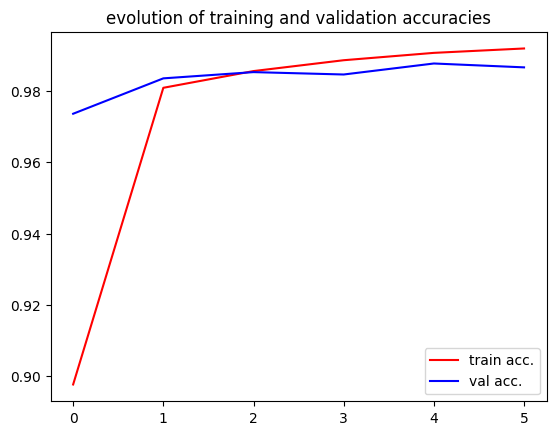

In [7]:
fig, ax = plt.subplots()
plt.title('evolution of training and validation accuracies')
ax.plot(np.arange(6), np.array(train_accs), color = 'r')
ax.plot(np.arange(6), np.array(val_accs), color = 'b')
ax.legend(['train acc.', 'val acc.'])


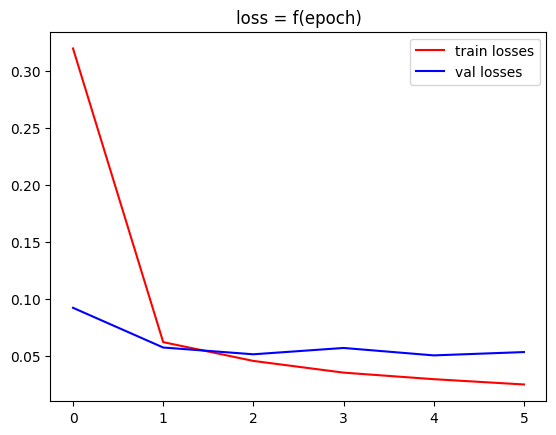

In [8]:
fig2, ax2 = plt.subplots()

plt.title('loss = f(epoch)')
ax2.plot(np.arange(6), np.array(train_losses), color = 'r')
ax2.plot(np.arange(6), np.array(val_losses), color = 'b')
ax2.legend(['train losses', 'val losses'])


**Exercise 5:** Complete the following perceptron (P60) to directly take MNIST images as input.
Compare the standalone perceptron to the CNN in terms of size (number of weights) and performance on a test set.

In [9]:
class P60(nn.Module):

    def __init__(self):
        super(P60, self).__init__()
        self.fc1 = nn.Linear(28*28, 50)  # 28*28 numel of MNIST images
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        # flattening x
        x = x.view(-1, 28*28)

        # apply first layer
        x = F.relu(self.fc1(x))

        # apply second layer
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

perceptron = P60()
optimizer = torch.optim.Adam(perceptron.parameters(), lr = 0.001)
loss_fn =  torch.nn.NLLLoss()

In [10]:
# Size comparison:

# CNN (don't forget the scalar biases, present by default):
print("CNN: \n")
print(" nb of parameters (conv) : " + str(10*1*5*5 + 10 + 10*10*5*5 + 10))
print(" nb of parameters (fc) : " + str(490*50 + 50 + 50*10 + 10))
print(" total: " + str(10*1*5*5 + 10 + 10*10*5*5 + 10 + \
                        490*50 + 50 + 50*10 + 10))

# Verification:
nb_weights = 0
for module in model.modules():
  if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
    for parameter in module.parameters():
      nb_weights += torch.numel(parameter)
print("verif : " + str(nb_weights))
print("\n")

# Perceptron P60:
print("P60: \n")
print("nb of parameters (fc) : " + str(28*28*50 + 50 + 50*10 + 10))

# Verification:
nb_weights = 0
for module in perceptron.modules():
  if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
    for parameter in module.parameters():
      nb_weights += torch.numel(parameter)
print("verif: " + str(nb_weights))

# There are more parameters (weights) in the perceptron.

CNN: 

 nb of parameters (conv) : 2770
 nb of parameters (fc) : 25060
 total: 27830
verif : 27830


P60: 

nb of parameters (fc) : 39760
verif: 39760


In [11]:
# Training the perceptron

train_losses = []
val_losses = []

train_accs = []
val_accs = []



# Initialize time
start_time = time.time()

# Learning Loop:
for epoch in range(6):
    print('epoch :' + str(epoch))

    running_loss_train = 0.
    running_corrects_train = 0.
    running_loss_val = 0.
    running_corrects_val = 0.

    # Training
    for x, label in train_loader:
        optimizer.zero_grad()
        output = perceptron(x)
        l = loss_fn(output, label)
        l.backward()
        optimizer.step()

        # Get predicted classes:
        _, preds = torch.max(output, 1)

        # Counters:
        running_loss_train += l.item() * x.shape[0]
        running_corrects_train += torch.sum(preds == label.data)

    # Calculate training scores and store:
    epoch_loss_train = running_loss_train / train_size
    epoch_acc_train = running_corrects_train.float() / train_size
    train_losses.append(epoch_loss_train)
    train_accs.append(epoch_acc_train)

    print('{} Loss: {:.4f} Acc: {:.4f}'.format(
        'train', epoch_loss_train, epoch_acc_train))


    # validation
    model.eval()

    for x, label in val_loader:

        with torch.no_grad():
            output = perceptron(x)
            l = loss_fn(output, label)

        # Get predicted classes:
        _, preds = torch.max(output, 1)

        # Counters:
        running_loss_val += l.item() * x.shape[0]
        running_corrects_val += torch.sum(preds == label.data)

    # Calculate training scores and store:
    epoch_loss_val = running_loss_val / val_size
    epoch_acc_val = running_corrects_val.float() / val_size
    val_losses.append(epoch_loss_val)
    val_accs.append(epoch_acc_val)


    print('{} Loss: {:.4f} Acc: {:.4f}'.format(
        'val', epoch_loss_val, epoch_acc_val))

    # Print elapsed time:
    elapsed_time = time.time() - start_time
    print(f'Time: {round(elapsed_time)} seconds')

epoch :0
train Loss: 0.5536 Acc: 0.8244
val Loss: 0.4684 Acc: 0.8499
Time: 30 seconds
epoch :1
train Loss: 0.4218 Acc: 0.8685
val Loss: 0.4139 Acc: 0.8724
Time: 60 seconds
epoch :2
train Loss: 0.3912 Acc: 0.8750
val Loss: 0.3795 Acc: 0.8804
Time: 92 seconds
epoch :3
train Loss: 0.3666 Acc: 0.8850
val Loss: 0.3790 Acc: 0.8886
Time: 122 seconds
epoch :4
train Loss: 0.3557 Acc: 0.8890
val Loss: 0.3694 Acc: 0.8907
Time: 152 seconds
epoch :5
train Loss: 0.3436 Acc: 0.8924
val Loss: 0.3847 Acc: 0.8788
Time: 182 seconds


In [ ]:
# Definition of the test set:
test_dataset = datasets.MNIST(root='./data',
                                  train=False,
                                  download=True,
                                  transform=tr)

# Note that our test test corresponds to the official MNIST validation step
num_images = len(test_dataset)
print(f"number of images in the test set: {num_images}")


# Definition of the train/val loaders
bs = 8
num_workers = 2 # try : print(os.cpu_count())

test_loader = DataLoader(test_dataset, batch_size=bs,
                         num_workers=num_workers)



# Performance comparison (on a test set):

test_accs_cnn = []
test_accs_perceptron = []
model.eval()
perceptron.eval()

# Testing Loop (only one epoch is needed)
for epoch in range(1):
    print('epoch :' + str(epoch))

    running_corrects_test_cnn = 0.
    running_corrects_test_perceptron = 0.

    # Training
    for x, label in test_loader:
      with torch.no_grad():
        output = model(x)
        # Counters:
        _, preds = torch.max(output, 1)
        running_corrects_test_cnn += torch.sum(preds == label.data)

        output = perceptron(x)
        # Counters:
        _, preds = torch.max(output, 1)
        running_corrects_test_perceptron += torch.sum(preds == label.data)

    # Calculate scores and store:
    epoch_acc_test_cnn = running_corrects_test_cnn.float() / len(test_dataset)
    epoch_acc_test_perceptron = running_corrects_test_perceptron.float() / len(test_dataset)


    print('{} Acc. cnn: {:.4f} Acc perceptron: {:.4f}'.format(
        'train', epoch_acc_test_cnn, epoch_acc_test_perceptron))



number of images in the test set: 10000
epoch :0
train Acc. cnn: 0.9882 Acc perceptron: 0.9537


**Note:** It is not easy to improve scores with a larger perceptron:

In [ ]:
class BiggerPerceptron(nn.Module):

    def __init__(self):
        super(BiggerPerceptron, self).__init__()
        self.fc01 = nn.Linear(28*28, 50)
        self.fc02 = nn.Linear(50, 200)
        self.fc1 = nn.Linear(200, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc01(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc02(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [ ]:
bigger_perceptron = BiggerPerceptron()
optimizer = torch.optim.Adam(bigger_perceptron.parameters(), lr = 0.001)
loss_fn =  torch.nn.NLLLoss()

In [ ]:
# bigger_perceptron :
nb_weights = 0
for module in bigger_perceptron.modules():
  if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
    for parameter in module.parameters():
      nb_weights += torch.numel(parameter)
print(nb_weights)

60010


In [ ]:
# Training the perceptron

train_losses = []
val_losses = []

train_accs = []
val_accs = []


# Initialize time
start_time = time.time()

# Learning Loop:
for epoch in range(50):
    print('epoch :' + str(epoch))

    running_loss_train = 0.
    running_corrects_train = 0.
    running_loss_val = 0.
    running_corrects_val = 0.

    # Training
    for x, label in train_loader:
        optimizer.zero_grad()
        output = bigger_perceptron(x)
        l = loss_fn(output, label)
        l.backward()
        optimizer.step()

        # Get predicted classes:
        _, preds = torch.max(output, 1)

        # Counters:
        running_loss_train += l.item() * x.shape[0]
        running_corrects_train += torch.sum(preds == label.data)

    # Calculate training scores and store:
    epoch_loss_train = running_loss_train / train_size
    epoch_acc_train = running_corrects_train.float() / train_size
    train_losses.append(epoch_loss_train)
    train_accs.append(epoch_acc_train)

    print('{} Loss: {:.4f} Acc: {:.4f}'.format(
        'train', epoch_loss_train, epoch_acc_train))


    # validation
    model.eval()

    for x, label in val_loader:

        with torch.no_grad():
            output = bigger_perceptron(x)
            l = loss_fn(output, label)

        # Get predicted classes:
        _, preds = torch.max(output, 1)

        # Counters:
        running_loss_val += l.item() * x.shape[0]
        running_corrects_val += torch.sum(preds == label.data)

    # Calculate training scores and store:
    epoch_loss_val = running_loss_val / val_size
    epoch_acc_val = running_corrects_val.float() / val_size
    val_losses.append(epoch_loss_val)
    val_accs.append(epoch_acc_val)


    print('{} Loss: {:.4f} Acc: {:.4f}'.format(
        'val', epoch_loss_val, epoch_acc_val))

    # Print elapsed time:
    elapsed_time = time.time() - start_time
    print(f'Time: {round(elapsed_time)} seconds')

epoch :0
train Loss: 0.8967 Acc: 0.7137
val Loss: 0.6999 Acc: 0.7872
Time: 39 seconds
epoch :1
train Loss: 0.6811 Acc: 0.7994
val Loss: 0.6167 Acc: 0.8112
Time: 78 seconds
epoch :2
train Loss: 0.6305 Acc: 0.8166
val Loss: 0.6274 Acc: 0.8158
Time: 118 seconds
epoch :3
train Loss: 0.6074 Acc: 0.8238
val Loss: 0.6190 Acc: 0.8181
Time: 157 seconds
epoch :4
train Loss: 0.5912 Acc: 0.8285
val Loss: 0.5808 Acc: 0.8264
Time: 197 seconds
epoch :5
train Loss: 0.5751 Acc: 0.8347
val Loss: 0.5937 Acc: 0.8292
Time: 237 seconds
epoch :6
train Loss: 0.5713 Acc: 0.8335
val Loss: 0.5953 Acc: 0.8257
Time: 276 seconds
epoch :7
train Loss: 0.5606 Acc: 0.8372
val Loss: 0.5747 Acc: 0.8382
Time: 315 seconds
epoch :8
train Loss: 0.5550 Acc: 0.8384
val Loss: 0.5529 Acc: 0.8384
Time: 354 seconds
epoch :9
train Loss: 0.5525 Acc: 0.8407
val Loss: 0.5838 Acc: 0.8397
Time: 392 seconds
epoch :10
train Loss: 0.5490 Acc: 0.8409
val Loss: 0.5817 Acc: 0.8392
Time: 431 seconds
epoch :11


KeyboardInterrupt: 

### **II.A.** Load and viz the Hymenoptera dataset:

Through a second image classification problem, we focus on two other important aspects of deep learning: speeding up the learning with GPU cards and the ability to use pretrained networks.

To illustrate the first aspect, we will use the GPUs available under Google Colab. To do this, before starting this part, go to **Modifier**/**Modifier les param du notebook** and select a GPU.

In [ ]:
# Check GPU availability
if torch.cuda.is_available():
  device = torch.device("cuda:0") # 0 is the index of the GPU
  print(torch.cuda.get_device_name(device))
else:
  print('Change the runtime type to GPU')

Tesla T4


Now let's download inputs (RGB images of bees or ants) and targets ("bee" or "ant").

In [ ]:
# download the dataset
! wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
! unzip -qq hymenoptera_data.zip

In [ ]:
dir_data = 'hymenoptera_data'
print(os.listdir(dir_data))

['val', 'train']


The dataset is in a standard format, and we can manipulate it with a ready-to-use dataset object of the datasets.ImageFolder class:

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        #transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(dir_data, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

print('Dataset sizs:' )
print(dataset_sizes)

Dataset sizs:
{'train': 244, 'val': 153}


Since the provided dataset is very small, we need to maximize its utility. We will produce new images through additional transformations that preserve the nature of the object (data augmentation). \
In the code, transforms.*RandomResizedCrop()*, *transforms.RandomHorizontalFlip()* and *transforms.RandomVerticalFlip()* apply horizontal or vertical axis symmetry with a probability of 1/2. Note that these transformations might not be suitable for other datasets like MNIST since the mirror image of a digit is generally not another digit. \
Some images are presented below.

In [ ]:
def imshow(inp, ax=None, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    if ax is None:
      plt.imshow(inp)
      plt.title(title)
    else:
      ax.imshow(inp)
      ax.set_title(title)

In [ ]:
def plot_batch(images, labels, class_names):
    num_images = len(images)
    fig, axs = plt.subplots(1, num_images, figsize=(15, 5))

    for i in range(num_images):
        axs[i].axis('off')
        imshow(images[i],axs[i],class_names[labels[i]])
    plt.show()

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
class_names = image_datasets['train'].classes
# Assuming `inputs` is a batch of images and `classes` are the corresponding class labels
plot_batch(inputs, classes, class_names)

### **II.B.** Adaptation of a ResNet18 architecture:

In this part, the lightest of the ResNet architectures is adapted to our binary classification problem and trained over one epoch.

**Exercise 6:**

- Load an untrained ResNet18. How many total weights does it contain? Check [here](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html).

- How many neurons does the last layer of the network have?

- Is there a softmax operation at the end of *ResNet.forward()*?

- Modify the last layer of the classifier so that it has as many neurons as there are classes in hymenoptera_data.

In [ ]:
model = models.resnet18(pretrained=False)

print(model)
nb_weights = 0
for module in model.modules():
  if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear)\
                                   or isinstance(module, nn.BatchNorm2d):
    for parameter in module.parameters():
      nb_weights += torch.numel(parameter)
print(nb_weights)

In [ ]:
# Neurons in the last layer
print(model.fc)
print(model.fc.out_features, "neurons")
# 1000 neurons

In [ ]:
# Modification of the last layer of the classifier
def get_model(pretrained):
  model = models.resnet18(pretrained=pretrained)

  num_ftrs = model.fc.in_features
  model.fc = nn.Linear(num_ftrs, 2)
  return model



Now, let's define the negative log-likelihood as the cost function. To compute the log-likelihood, we could add a LogSoftmax layer to the ResNet. Another common way to do that is to use a loss function that includes *LogSoftmax*. In this regard, in PyTorch,  *nn.CrossEntropyLoss* combines both *LogSoftmax* and *NLLLoss*.

In [ ]:
loss_fn = nn.CrossEntropyLoss()

Finally, let's define a function that incorporates the training loop:

In [ ]:
def train_model(dataloaders, model, loss_fn, optimizer, num_epochs=1):
    since = time.time()

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                # Weights are not updated during the validation phase

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = loss_fn(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {100*epoch_acc:.2f}%')

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    return model

**Exercise 7:** With the *train_model* function, train the ResNet over one epoch with mini-batches of 64 images.

In [ ]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}

In [ ]:
%%timeit -n 1 -r 2
# Training over 1 epoch:
model = get_model(pretrained=False)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
model = train_model(dataloaders, model, loss_fn, optimizer, num_epochs=1)

Epoch 0/0
----------


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


train Loss: 0.6798 Acc: 56.56%
val Loss: 0.6767 Acc: 58.82%
Training complete in 0m 54s
Epoch 0/0
----------
train Loss: 0.8126 Acc: 50.41%
val Loss: 0.7243 Acc: 45.10%
Training complete in 0m 51s
52.3 s ± 1.31 s per loop (mean ± std. dev. of 2 runs, 1 loop each)


### **II.C.** Using a Graphics Card:

With more than 10 million parameters, training a ResNet18 on a CPU is much slower than the networks in Part I. \
Let's repeat the same training using the GPU.

In [ ]:
print(f'Runtime device :{device}')

# Load the model to the GPU:
model = model.to(device)

Runtime device :cuda:0


To load a torch.tensor on GPU, the syntax is the same:

In [ ]:
x = torch.rand(2,1,4,4)
print("On CPU :\n",x)
x = x.to(device)
# Note: You can also use .cuda() without specifying the device name
# but this method is not recommended especially in a multi-gpu environment
print("On GPU :\n",x)

# bring back the x tensor to the CPU RAM:
x = x.to('cpu') # or x.cpu()
print('Back to CPU:\n',x)

On CPU :
 tensor([[[[0.8997, 0.3238, 0.1675, 0.0810],
          [0.9166, 0.2653, 0.4745, 0.2725],
          [0.3267, 0.2187, 0.9921, 0.2195],
          [0.6508, 0.7574, 0.6040, 0.5157]]],


        [[[0.7806, 0.4837, 0.2521, 0.3249],
          [0.6147, 0.6107, 0.5501, 0.8463],
          [0.5577, 0.7939, 0.9760, 0.2241],
          [0.1178, 0.7931, 0.4396, 0.6614]]]])
On GPU :
 tensor([[[[0.8997, 0.3238, 0.1675, 0.0810],
          [0.9166, 0.2653, 0.4745, 0.2725],
          [0.3267, 0.2187, 0.9921, 0.2195],
          [0.6508, 0.7574, 0.6040, 0.5157]]],


        [[[0.7806, 0.4837, 0.2521, 0.3249],
          [0.6147, 0.6107, 0.5501, 0.8463],
          [0.5577, 0.7939, 0.9760, 0.2241],
          [0.1178, 0.7931, 0.4396, 0.6614]]]], device='cuda:0')
Back to CPU:
 tensor([[[[0.8997, 0.3238, 0.1675, 0.0810],
          [0.9166, 0.2653, 0.4745, 0.2725],
          [0.3267, 0.2187, 0.9921, 0.2195],
          [0.6508, 0.7574, 0.6040, 0.5157]]],


        [[[0.7806, 0.4837, 0.2521, 0.3249],
       

**Exercise 8:**
- Complete the fonction *train_model_gpu* to train the model on GPU.
- Compare the CPU and GPU training times.
- What are the validation scores after 20 epochs on GPUs ?

In [ ]:
def train_model_gpu(dataloaders, model, loss_fn, optimizer, num_epochs=1):
    # Record the starting time
    since = time.time()
    # Loop through epochs
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Iterate through training and validation phases
        for phase in ['train', 'val']:
            # Set the model to training mode during the training phase, and evaluation mode during validation
            if phase == 'train':
                model.train()
            else:
                model.eval()

            # Initialize counters for loss and correct predictions
            running_loss = 0.0
            running_corrects = 0

            # Iterate through batches in the data loader
            for inputs, labels in dataloaders[phase]:
                # Move inputs and labels to the specified device (GPU)
                ### BEGIN SOLUTION
                inputs = inputs.to(device)
                labels = labels.to(device)
                ### END SOLUTION

                # Zero the gradients in the optimizer (same as in train_model())
                ### BEGIN SOLUTION
                optimizer.zero_grad()
                ### END SOLUTION
                # Forward pass: compute model outputs and predictions (same as in train_model())
                with torch.set_grad_enabled(phase == 'train'):
                    ### BEGIN SOLUTION
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = loss_fn(outputs, labels)
                    ### END SOLUTION
                    # Backward pass and optimization step if in the training phase (same as in train_model())
                    ### BEGIN SOLUTION
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    ### END SOLUTION
                # Update counters
                running_loss += loss.item() * inputs.size(0)
                acc = torch.sum(preds == labels.data)
                # The 'acc' tensor is distributed across different parts of the GPU
                # Gather the 'acc' tensor on the CPU before accumulation
                # running_corrects += ...
                ### BEGIN SOLUTION
                running_corrects += acc.cpu()
                ### END SOLUTION

            # Calculate average loss and accuracy for the epoch
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            # Print epoch statistics
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {100*epoch_acc:.2f}%')

    # Calculate and print the total training time
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    # Return the trained model
    return model




In [ ]:
%%timeit -n 1 -r 2
model = get_model(pretrained=False).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

model = train_model_gpu(dataloaders, model, loss_fn, optimizer, num_epochs=1)


Epoch 0/0
----------
train Loss: 0.7066 Acc: 45.90%
val Loss: 0.7005 Acc: 45.10%
Training complete in 0m 3s
Epoch 0/0
----------
train Loss: 0.7827 Acc: 49.59%
val Loss: 0.6860 Acc: 54.25%
Training complete in 0m 3s
2.96 s ± 21.8 ms per loop (mean ± std. dev. of 2 runs, 1 loop each)


### **II.D.** Impact of pretraining on performance:

Training is faster on a GPU, but it only leads to a very poor score, barely better than random chance. To improve performance, a simple idea is to use a network trained on a similar (or more general) task as a starting point for learning. Here, it works particularly well with networks trained on ImageNet, whose convolutional filters are already very rich.

**Note:**
This method is refered to as **fine-tuning** a **pretrained model**.

**Exercise 9:** Compare two ResNet18 trainings, one randomly initialized and the other pre-trained, using learning curves, over 25 epochs.

In [ ]:
def train_model_gpu_(dataloaders, model, loss_fn, optimizer, num_epochs=1):

    train_accs = []
    val_accs = []

    # Loop through epochs
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Iterate through training and validation phases
        for phase in ['train', 'val']:
            # Set the model to training mode during the training phase, and evaluation mode during validation
            if phase == 'train':
                model.train()
            else:
                model.eval()

            # Initialize counters for loss and correct predictions
            running_loss = 0.0
            running_corrects = 0

            # Iterate through batches in the data loader
            for inputs, labels in dataloaders[phase]:
                # Move inputs and labels to the specified device (GPU)
                ### BEGIN SOLUTION
                inputs = inputs.to(device)
                labels = labels.to(device)
                ### END SOLUTION

                # Zero the gradients in the optimizer (same as in train_model())
                ### BEGIN SOLUTION
                optimizer.zero_grad()
                ### END SOLUTION
                # Forward pass: compute model outputs and predictions (same as in train_model())
                with torch.set_grad_enabled(phase == 'train'):
                    ### BEGIN SOLUTION
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = loss_fn(outputs, labels)
                    ### END SOLUTION
                    # Backward pass and optimization step if in the training phase (same as in train_model())
                    ### BEGIN SOLUTION
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    ### END SOLUTION
                # Update counters
                running_loss += loss.item() * inputs.size(0)
                acc = torch.sum(preds == labels.data)
                # The 'acc' tensor is distributed across different parts of the GPU
                # Gather the 'acc' tensor on the CPU before accumulation
                # running_corrects += ...
                ### BEGIN SOLUTION
                running_corrects += acc.cpu()
                ### END SOLUTION

            # Calculate average loss and accuracy for the epoch
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase =='train':
              train_accs.append(epoch_acc)
            elif phase =='val':
              val_accs.append(epoch_acc)

            # Print epoch statistics
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {100*epoch_acc:.2f}%')


    # Return the trained model, train_accs and val_accs
    return model, train_accs, val_accs

In [ ]:
max_epochs = 25
# Learning "from scratch" (random weights) :
# get the model
# Put the model on GPU
# get the loss, optimize, the scheduler and starting the training
# ...
# resnet_scratch, accs_scratch = train(...)

resnet_scratch = get_model(pretrained=False)
resnet_scratch = resnet_scratch.to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet_scratch.parameters(), lr=0.001,
                            momentum=0.9)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10,
                                                   gamma=0.1)
resnet_scratch, _, accs_scratch =  train_model_gpu_(dataloaders,
                                                    resnet_scratch,
                                                    loss_function,
                                                    optimizer,
                                                    num_epochs=max_epochs)

Epoch 0/24
----------


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


train Loss: 0.7118 Acc: 50.41%
val Loss: 0.6933 Acc: 54.25%
Epoch 1/24
----------
train Loss: 0.6811 Acc: 55.74%
val Loss: 0.6836 Acc: 53.59%
Epoch 2/24
----------
train Loss: 0.6609 Acc: 59.43%
val Loss: 0.6875 Acc: 50.98%
Epoch 3/24
----------
train Loss: 0.6479 Acc: 62.70%
val Loss: 0.6856 Acc: 53.59%
Epoch 4/24
----------
train Loss: 0.6172 Acc: 64.34%
val Loss: 0.6709 Acc: 54.90%
Epoch 5/24
----------
train Loss: 0.6105 Acc: 64.75%
val Loss: 0.6575 Acc: 64.71%
Epoch 6/24
----------
train Loss: 0.6042 Acc: 65.16%
val Loss: 0.6507 Acc: 62.09%
Epoch 7/24
----------
train Loss: 0.5938 Acc: 66.80%
val Loss: 0.6368 Acc: 62.75%
Epoch 8/24
----------
train Loss: 0.5831 Acc: 68.03%
val Loss: 0.6266 Acc: 65.36%
Epoch 9/24
----------
train Loss: 0.5820 Acc: 66.39%
val Loss: 0.6123 Acc: 68.63%
Epoch 10/24
----------
train Loss: 0.5667 Acc: 68.44%
val Loss: 0.6109 Acc: 66.67%
Epoch 11/24
----------
train Loss: 0.5437 Acc: 71.72%
val Loss: 0.6084 Acc: 67.97%
Epoch 12/24
----------
train Loss: 0

In [ ]:
# fine tuning a pretrained model:
# ...
# resnet_ft, accs_ft = train(...)

resnet_ft = get_model(pretrained=True)

resnet_ft = resnet_ft.to(device)

optimizer = torch.optim.SGD(resnet_ft.parameters(), lr=0.001,
                            momentum=0.9)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10,
                                                   gamma=0.1)
resnet_ft, _, accs_ft = train_model_gpu_(dataloaders,
                                          resnet_ft,
                                          loss_function,
                                          optimizer,
                                          num_epochs=max_epochs)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/24
----------
train Loss: 0.7628 Acc: 49.18%
val Loss: 0.6632 Acc: 62.75%
Epoch 1/24
----------
train Loss: 0.6195 Acc: 66.39%
val Loss: 0.5297 Acc: 74.51%
Epoch 2/24
----------
train Loss: 0.5085 Acc: 77.87%
val Loss: 0.4062 Acc: 80.39%
Epoch 3/24
----------
train Loss: 0.3682 Acc: 88.52%
val Loss: 0.3212 Acc: 86.93%
Epoch 4/24
----------
train Loss: 0.3127 Acc: 90.16%
val Loss: 0.2650 Acc: 91.50%
Epoch 5/24
----------
train Loss: 0.2750 Acc: 90.57%
val Loss: 0.2355 Acc: 92.81%
Epoch 6/24
----------
train Loss: 0.2149 Acc: 93.85%
val Loss: 0.2170 Acc: 93.46%
Epoch 7/24
----------
train Loss: 0.1828 Acc: 95.08%
val Loss: 0.2053 Acc: 93.46%
Epoch 8/24
----------
train Loss: 0.1875 Acc: 94.67%
val Loss: 0.1952 Acc: 93.46%
Epoch 9/24
----------
train Loss: 0.1712 Acc: 92.62%
val Loss: 0.1896 Acc: 94.12%
Epoch 10/24
----------
train Loss: 0.1434 Acc: 96.31%
val Loss: 0.1856 Acc: 94.77%
Epoch 11/24
----------
train Loss: 0.1455 Acc: 95.08%
val Loss: 0.1819 Acc: 94.77%
Epoch 12/24
--

In [ ]:

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))
# Plot the data with improved style
epochs = np.arange(max_epochs)


ax.plot(epochs, 100 * np.array(accs_scratch), color='blue',
        label='Training from Scratch', marker='o', linestyle='-', linewidth=2)
ax.plot(epochs, 100 * np.array(accs_ft), color='green',
        label='Fine Tuning', marker='s', linestyle='-', linewidth=2)

# Assuming accs_scratch and accs_ft are dictionaries with 'val' as a key
# you can use the following lines
#ax.plot(epochs, 100 * np.array(accs_scratch['val']), color='skyblue',
#        label='Training from Scratch', marker='o', linestyle='-', linewidth=2)
#ax.plot(epochs, 100 * np.array(accs_ft['val']), color='lightgreen',
#        label='Fine Tuning', marker='s', linestyle='-', linewidth=2)

# Set title and axis labels
ax.set_title('Validation Accuracy Over Epochs', fontsize=16)
ax.set_ylabel("Accuracy (%)", fontsize=14)
ax.set_xlabel("Epochs", fontsize=14)

# Set grid for better readability
ax.grid(True, linestyle='--', alpha=0.7)
# Add legend with a border and shadow
ax.legend(frameon=True, fancybox=True, shadow=True, framealpha=0.9, fontsize=12)
plt.show()

The fine-tuning approach has many variations that fit into the broader framework of **transfer learning**. Partial fine-tuning, as illustrated in the following exercise, is one of these variations.

**Exercise 10:** Instead of retraining all the weights, you can simply use the weights of the classifier. This is referred to as *freezing* the other weights during retraining. \\
Implement this approach and compare it with the previous ones.

In [ ]:
resnet = torchvision.models.resnet18(pretrained=True)

num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 2)

# freeze all the layers except the classifier (the last dense layers at end)
# using this snippet :

for module in resnet.modules() :
  if isinstance(module, nn.Conv2d) or isinstance(module, nn.BatchNorm2d):
    for param in module.parameters():
      param.requires_grad = False


freezed_resnet = resnet.to(device)
# train the model
# ...
# freezed_resnet, accs_freezing = train(...)


optimizer = torch.optim.SGD(freezed_resnet.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

freezed_resnet = freezed_resnet.to(device)
freezed_resnet, _, accs_freezing = train_model_gpu_(dataloaders,
                                                freezed_resnet,
                                                loss_function,
                                                optimizer,
                                                num_epochs=max_epochs)


In [ ]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))
# Plot the data with improved style
epochs = np.arange(max_epochs)


ax.plot(epochs, 100 * np.array(accs_scratch), color='skyblue',
        label='Training from Scratch', marker='o', linestyle='-', linewidth=2)
ax.plot(epochs, 100 * np.array(accs_ft), color='lightgreen',
        label='Fine Tuning', marker='s', linestyle='-', linewidth=2)
ax.plot(epochs, 100 * np.array(accs_freezing), color='g',
        label='Fine Tuning with freezed weights', marker='s', linestyle='-', linewidth=2)


# Set title and axis labels
ax.set_title('Validation Accuracy Over Epochs', fontsize=16)
ax.set_ylabel("Accuracy (%)", fontsize=14)
ax.set_xlabel("Epochs", fontsize=14)

# Set grid for better readability
ax.grid(True, linestyle='--', alpha=0.7)
# Add legend with a border and shadow
ax.legend(frameon=True, fancybox=True, shadow=True, framealpha=0.9, fontsize=12)
plt.show()

In the end, for this small dataset, retraining the last layer performs just as well as global training. To conclude, let's make some predictions with the model on the validation dataset:

In [ ]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(25,num_images//5*5))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//5, 5, images_so_far)
                ax.axis('off')
                imshow(inputs.cpu().data[j],ax,'Predicted: {}'.format(class_names[preds[j]]))

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


visualize_model(resnet_ft, num_images=10)